# Week 6 - Decision Trees

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [2]:
data_filtered = data.loc[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
data_filtered.fillna(0, inplace=True)
data_filtered['median_house_value'] = np.log1p(data_filtered['median_house_value'])
data_filtered.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN


In [3]:
from sklearn.model_selection import train_test_split

train_data_full, test_data = train_test_split(data_filtered, test_size=0.2, random_state=1)
train_data, val_data = train_test_split(train_data_full, test_size=0.25, random_state=1)

y_train = train_data.pop('median_house_value')
y_val = val_data.pop('median_house_value')
y_test = test_data.pop('median_house_value')

In [4]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_data.to_dict(orient='records'))
X_val = dv.transform(val_data.to_dict(orient='records'))


## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [5]:
from sklearn.tree import DecisionTreeRegressor, export_text


model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

print(export_text(model, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



`ocean_proximity` is used to split the data.

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
pred = rfr.predict(X_val)
mse(y_val, pred)**0.5

0.24527740463893763

The RMSE of this model on vlaidation data is `0.245`

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

estimator_values = range(10, 200+1, 10)
results = dict()

for n in estimator_values:
    rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    pred = rfr.predict(X_val)
    rmse = mse(y_val, pred)**0.5
    results[n] = np.round(rmse, 3)

# print(results)


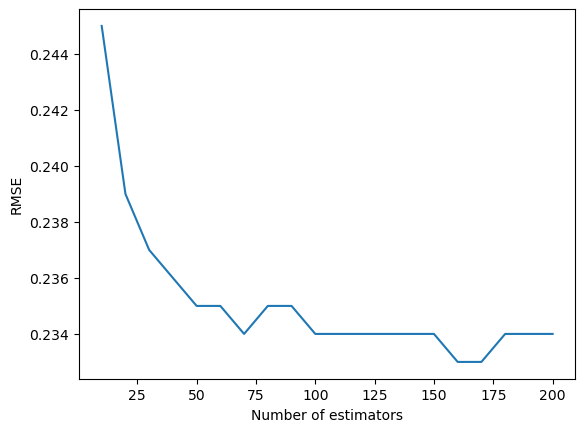

In [8]:
x = list(results.keys())
y = list(results.values())
plt.plot(x, y)
plt.xlabel('Number of estimators')
plt.ylabel('RMSE')
plt.show()

It seems `160` is the best number of estimators.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [9]:
max_depth = [10, 15, 20, 25]
n_estimators = range(10, 201, 10)

results = list()
depth_results = dict()
for depth in max_depth:
    for n in estimator_values:
        rfr = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rfr.fit(X_train, y_train)
        pred = rfr.predict(X_val)
        rmse = mse(y_val, pred)**0.5
        results.append(rmse)
    depth_results[depth] = np.mean(results)

depth_results

{10: 0.24552591787825445,
 15: 0.2407477680789433,
 20: 0.23888786781813207,
 25: 0.2378643430752927}

We observe that `max_depth=25` is the best values

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [10]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
rfr_importance = pd.DataFrame({'features': dv.feature_names_, 'importance':rfr.feature_importances_})
rfr_importance.sort_values(by='importance', ascending=False)

,features,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030317
7,population,0.027136
9,total_rooms,0.021417
8,total_bedrooms,0.015852
0,households,0.015136


We observe that `median_income` is the most important fatures.

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [11]:
!pip install xgboost

In [12]:
import xgboost as xgb

In [13]:
features = dv.get_feature_names_out()
features = [f.replace('=<', '_').replace('=', '_') for f in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [14]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
pred = model.predict(dval)
mse(pred, y_val) ** 0.5

0.228623199980106

In [15]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
pred = model.predict(dval)
mse(pred, y_val) ** 0.5

0.23208927121609343

We observe that `eta=0.3` provided better values.